# Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import random
import shutil
import itertools
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from matplotlib.image import imread

# Google Colab | Kaggle API setup | Dataset download

### Google setup ☁️

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ryotaro94","key":"fe8dfbd6b5ddb823f4d532e6555b70b1"}'}

### Kaggle API setup ✔️

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir project

### Dataset downlaod 💾

In [ ]:
!kaggle datasets list -s fire
!kaggle datasets download phylake1337/fire-dataset
!unzip /content/fire-dataset.zip -d /content/project

In [ ]:
!mv /content/project/fire_dataset/fire_images/* /content/project/
!mv /content/project/fire_dataset/non_fire_images/* /content/project/

In [ ]:
# Remove .zip and files
!rm /content/fire-dataset.zip
!rmdir /content/project/fire_dataset/*
!rmdir /content/project/fire_dataset

# Image Preprocesing | Exploratory Data Analysis (EDA)

In [ ]:
# Organize data inro train, valid, test dirs

os.chdir('/content/project')
if os.path.isdir('train/fire') is False:
  os.makedirs('train/fire')
  os.makedirs('train/non_fire')
  os.makedirs('valid/fire')
  os.makedirs('valid/non_fire')
  os.makedirs('test/fire')
  os.makedirs('test/non_fire')

  for c in random.sample(glob.glob('fire*'), 100):
    shutil.move(c, 'train/fire')
  for c in random.sample(glob.glob('non_fire*'), 100):
    shutil.move(c, 'train/non_fire')
  for c in random.sample(glob.glob('fire*'), 50):
    shutil.move(c, 'valid/fire')
  for c in random.sample(glob.glob('non_fire*'), 50):
    shutil.move(c, 'valid/non_fire')
  for c in random.sample(glob.glob('fire*'), 20):
    shutil.move(c, 'test/fire')
  for c in random.sample(glob.glob('non_fire*'), 20):
    shutil.move(c, 'test/non_fire')

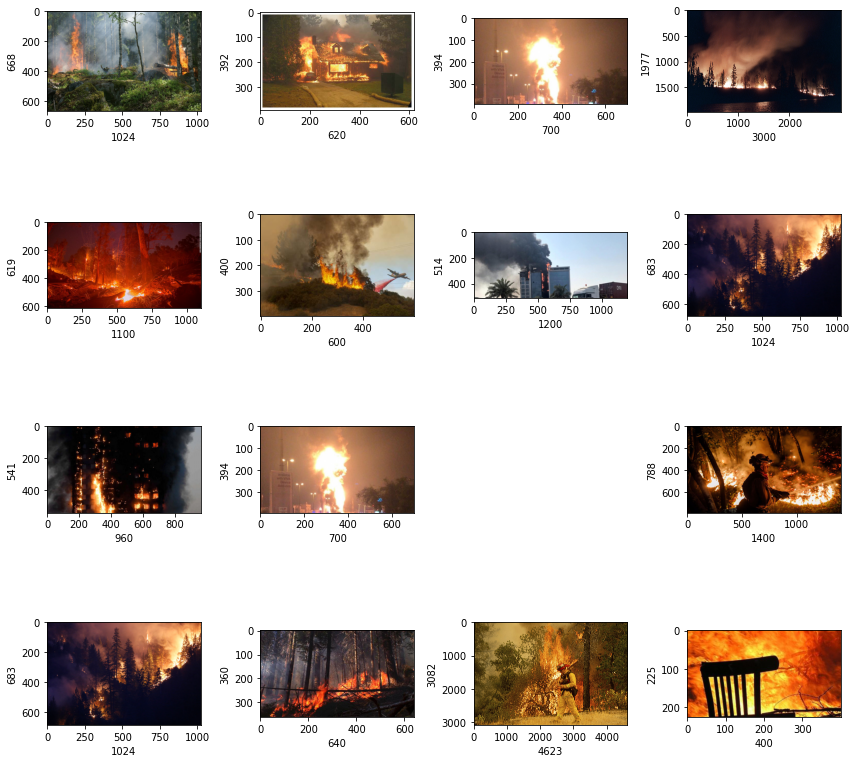

In [ ]:
# Plotting random 16 original images (fire)

plt.figure(figsize=(12,12))
path = "/content/project/train/fire"
for i in range (1,17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))), format='jpg')
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)

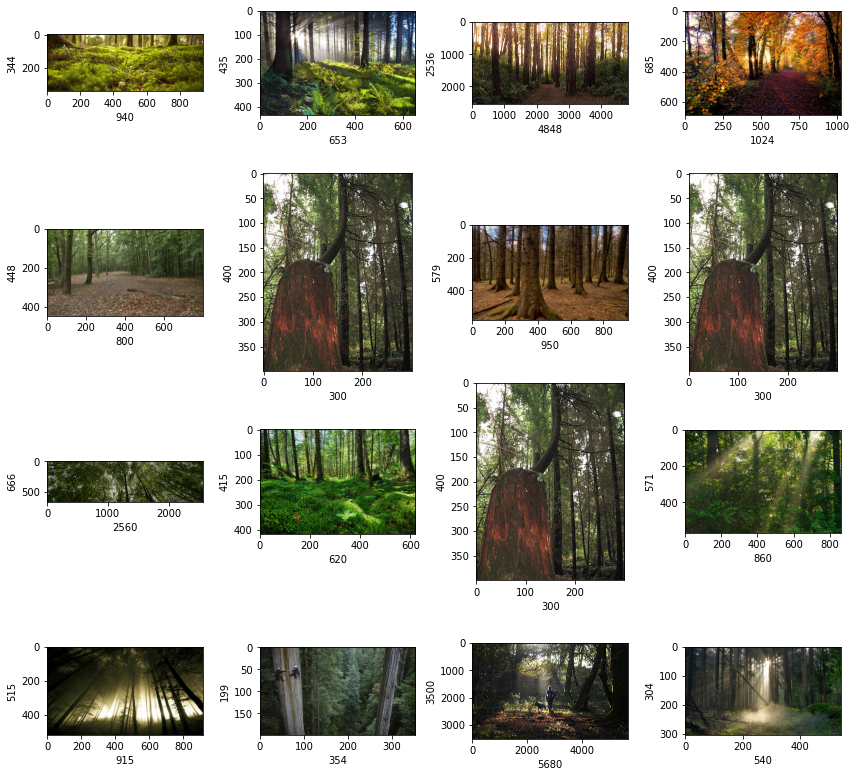

In [ ]:
# Plotting random 16 original images (non_fire)

plt.figure(figsize=(12,12))
path = "/content/project/train/non_fire"
for i in range (1,17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))), format='jpg')
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)

In [ ]:
# Paths

train_path = "/content/project/train"
valid_path = "/content/project/valid"
test_path = '/content/project/test'

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(105,165), classes=['fire', 'non_fire'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(105,165), classes=['fire', 'non_fire'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(105,165), classes=['fire', 'non_fire'], batch_size=10, shuffle=False)   

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
assert train_batches.n == 200
assert valid_batches.n == 100
assert test_batches.n == 40
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [ ]:
imgs, labels = next(train_batches)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 10 columns

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


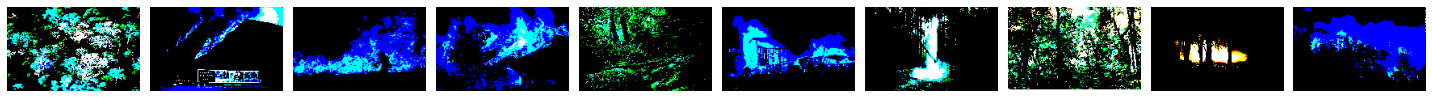

In [ ]:
plotImages(imgs)
print(labels)

# Modeling | Deployment | Neural Netowork

In [ ]:
model = Sequential()

#
model.add(Conv2D(32,(3,3),activation="relu",
                 input_shape=(105,165,3)))
model.add(MaxPool2D((2,2)))

#
model.add(Conv2D(64,(3,3),
                 activation="relu",padding="same"))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2)))

#
model.add(Conv2D(128,(3,3),
                 activation="relu",padding="same"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))


#
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="sigmoid"))

In [ ]:
model.compile(optimizer="adam" ,loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 103, 163, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 81, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 51, 81, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 51, 81, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 40, 128)      

In [ ]:
model.fit(train_batches, validation_data=valid_batches, epochs=10, verbose=1)

Epoch 1/10
20/20 [==============================] - 14s 591ms/step - loss: 71.7706 - accuracy: 0.6500 - val_loss: 0.3489 - val_accuracy: 0.8800
Epoch 2/10
20/20 [==============================] - 10s 497ms/step - loss: 0.4016 - accuracy: 0.8900 - val_loss: 0.2552 - val_accuracy: 0.9200
Epoch 3/10
20/20 [==============================] - 10s 495ms/step - loss: 0.2449 - accuracy: 0.9250 - val_loss: 0.1988 - val_accuracy: 0.9100
Epoch 4/10
20/20 [==============================] - 10s 528ms/step - loss: 0.1922 - accuracy: 0.9200 - val_loss: 0.2316 - val_accuracy: 0.9300
Epoch 5/10
20/20 [==============================] - 9s 489ms/step - loss: 0.1762 - accuracy: 0.9400 - val_loss: 0.1487 - val_accuracy: 0.9400
Epoch 6/10
20/20 [==============================] - 10s 496ms/step - loss: 0.2199 - accuracy: 0.9600 - val_loss: 0.1513 - val_accuracy: 0.9600
Epoch 7/10
20/20 [==============================] - 10s 470ms/step - loss: 0.1155 - accuracy: 0.9450 - val_loss: 0.1782 - val_accuracy: 0.9500

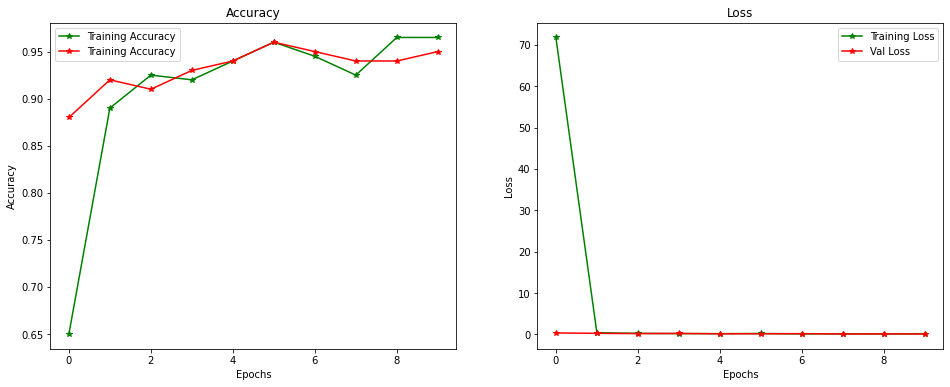

In [ ]:
# Ploting Accuracy and Loss metrics.

results = pd.DataFrame(model.history.history)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(results['accuracy'], label='Training Accuracy',color='green',marker='*')
plt.plot(results['val_accuracy'], label='Training Accuracy',color='red',marker='*')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results['loss'], label='Training Loss',color='green',marker='*')
plt.plot(results['val_loss'], label='Val Loss',color='red',marker='*')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
